## Quickstart with the active learning module

[Active learning]( https://en.wikipedia.org/wiki/Active_learning_(machine_learning) ) is method that aims to query new data to be labelled, to improve the machine learning model. We suppose that we have a large pool of unlabelled data. Based on a predefined heuristic strategy, an Oracle will select a certain number of data `num_annotate` that will be annotated and used to re-train the model. Step after step, we should see an improvement in the model's performances. A baseline for the strategy would be to take the data randomly. 

## The dataset

We will use the sklearn [digits dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) where each datapoint is a 8x8 image of a digit that we aim to classify with a neural network.

In [1]:
import torch
from torch.utils.data import Dataset
from sklearn.datasets import load_digits

def get_classification_dataset(labelled_size=None):
    class DigitDataset(Dataset):
        """ Sklearn digit dataset
        """
        def __init__(self):
            super(DigitDataset, self).__init__()
            sk_x, sk_y = load_digits(return_X_y=True)
            self.x = torch.FloatTensor(sk_x) # data 
            self.y = torch.LongTensor(sk_y) # target

        def __len__(self):
            return self.x.shape[0]

        def __getitem__(self, idx):
            return self.x[idx], self.y[idx]

    ds = DigitDataset()
    train_ds, valid_ds, test_ds = torch.utils.data.random_split(ds, [1400, 200, 197])
    train_indices = train_ds.indices
    valid_indices = valid_ds.indices
    test_indices = test_ds.indices
    labelled_indices = (
        train_indices[:labelled_size] if not labelled_size is None else None
    )

    return DataManager(
        ds,
        train_indices=train_indices,
        validation_indices=valid_indices,
        test_indices=test_indices,
        labelled_indices=labelled_indices,
        loader_batch_size=10,
    )

## The model

The model here is build with the [Pytorch Lightning module](https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html). 

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from pytorch_lightning import LightningModule

class DigitClassifier(LightningModule):
    """Custom module for a simple convnet classifier"""

    def __init__(self, dropout_rate=0):
        super(DigitClassifier, self).__init__()
        self.layer_1 = nn.Linear(8*8, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer_3(x)
        x = F.log_softmax(x, dim=1)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("loss", loss.item())
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("test_loss", loss)

        # compute accuracy
        _, y_pred = torch.max(logits.data, 1)
        accuracy = accuracy_score(y, y_pred)
        self.log("accuracy", accuracy)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

## The query strategy and the active learning loop


In order to perform Active Learning, we will need three principal objects: 
* **model**: A model written with Pytorch Lightning, that takes in input a neural networks and a set of arguments (ie: the number of epochs) used for training.
* **data manager**: A data manager that will handle, after each query, which data becomes labelled and is transfered to the training set, and what is the remaining unlabelled data. The data manager is working closely with the active learning strategy, and for each new strategy, it needs to be reloaded.
* **strategy**: An active Learning strategy, that depends on the tasks (agnotic, classification or regression), and takes in input both the model and the data_manager.

In [3]:
# Avoid printing logs with Pytorch Lightning
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# Create active learning model 
from pyrelational.models.mcdropout_model import LightningMCDropoutModel
model = LightningMCDropoutModel(DigitClassifier, {}, {"epochs": 4})

In [4]:
%%capture
from pyrelational.data.data_manager import DataManager
from pyrelational.strategies.classification import (
    LeastConfidenceStrategy,
    MarginalConfidenceStrategy,
    RatioConfidenceStrategy,
    EntropyClassificationStrategy,
)
query = dict()


# Least confidence strategy
dm = get_classification_dataset()
strategy = LeastConfidenceStrategy(data_manager=dm, model=model)
strategy.theoretical_performance()
strategy.full_active_learning_run(num_annotate=250)
query['LeastConfidence'] = strategy.performance_history()

# Maginal confidence
dm = get_classification_dataset()
strategy = MarginalConfidenceStrategy(data_manager=dm, model=model)
strategy.theoretical_performance()
strategy.full_active_learning_run(num_annotate=250)
query['MarginalConfidence'] = strategy.performance_history()

# Ratio confidence
dm = get_classification_dataset()
strategy = RatioConfidenceStrategy(data_manager=dm, model=model)
strategy.theoretical_performance()
strategy.full_active_learning_run(num_annotate=250)
query['RatioConfidence'] = strategy.performance_history()

# Entropy classification
dm = get_classification_dataset()
strategy = EntropyClassificationStrategy(data_manager=dm, model=model)
strategy.theoretical_performance()
strategy.full_active_learning_run(num_annotate=250)
query['EntropyClassification'] = strategy.performance_history()


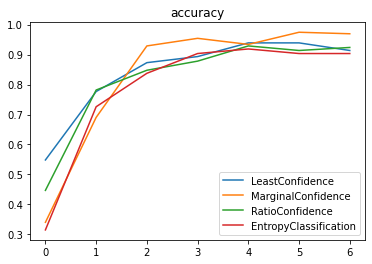

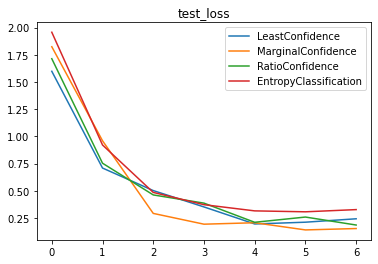

In [6]:
import matplotlib.pyplot as plt

query_keys = ['LeastConfidence', 'MarginalConfidence', 'RatioConfidence', 'EntropyClassification']
metric_keys = ['accuracy', 'test_loss']

for metric in metric_keys :
    for key in query_keys:
        plt.plot(query[key][metric], label=key)
    plt.legend()
    plt.title('{}'.format(metric))
    plt.show()